# Testing GOAT
Pranav Mathur

In [1]:
import numpy as np
from numpy.polynomial import chebyshev
import matplotlib.pyplot as plt
from goat_optimization import run_goat_optimization, to_infidelity_hessian
from qutip_gate_simulation import data_from_tstep, simulate_gate, calculate_fidelity
from scipy.optimize import NonlinearConstraint

## Rydberg Gates

In [2]:
# define hamiltonians
H0 = np.zeros((4, 4))

H_plus = np.array([[0, 0, 1/2, 0],
                   [0, 0, 0, np.sqrt(2)/2],
                   [0, 0, 0, 0],
                   [0, 0, 0, 0]])
H_minus = np.array([[0, 0, 0, 0],
                    [0, 0, 0, 0],
                    [1/2, 0, 0, 0],
                    [0, np.sqrt(2)/2, 0, 0]])
H_controls = [H_plus, H_minus]

U_target = np.array([[1, 0],
                     [0, -1]])

# U_target = np.array([[1, 0, 0, 0],
#                      [0, 1, 0, 0],
#                      [0, 0, 1, 0],
#                      [0, 0, 0, -1]])

In [3]:
# define control functions
def to_control_func_plus(t, alpha, control_extra_params=None):
    """control_extra_params should be {"Omega_max", "t_max", "n_pieces"}"""
    dt = control_extra_params["t_max"] / control_extra_params["n_pieces"]
    j = int(t / dt)
    return control_extra_params["Omega_max"] * np.exp(1j * alpha[j])

def to_control_func_minus(t, alpha, control_extra_params=None):
    """control_extra_params should be {"Omega_max", "t_max", "n_pieces"}"""
    dt = control_extra_params["t_max"] / control_extra_params["n_pieces"]
    j = int(t / dt)
    return control_extra_params["Omega_max"] * np.exp(-1j * alpha[j])

def to_control_param_derivs(t, alpha, control_extra_params=None):
    """control_extra_params should be {"Omega_max", "t_max", "n_pieces"}"""
    dt = control_extra_params["t_max"] / control_extra_params["n_pieces"]
    j = int(t / dt)
    deriv_matrix = np.zeros((2, alpha.size), dtype=complex)
    deriv_matrix[0][j] = 1j * control_extra_params["Omega_max"] * np.exp(1j * alpha[j])
    deriv_matrix[1][j] = -1j * control_extra_params["Omega_max"] * np.exp(-1j * alpha[j])
    return deriv_matrix

def chebyshev_control_func_plus(t, alpha, control_extra_params=None):
    return control_extra_params["Omega_max"] * np.exp( 1j * chebyshev.chebval( (2/control_extra_params["t_max"])*t-1, alpha) )

def chebyshev_control_func_minus(t, alpha, control_extra_params=None):
    return control_extra_params["Omega_max"] * np.exp( -1j * chebyshev.chebval( (2/control_extra_params["t_max"])*t-1, alpha) )

def chebyshev_control_param_derivs(t, alpha, control_extra_params=None):
    deriv_matrix = np.zeros((2, alpha.size), dtype=complex)
    phase = chebyshev.chebval((2/control_extra_params["t_max"])*t-1, alpha)
    plus_exp_val = 1j * control_extra_params["Omega_max"] * np.exp(1j * phase)
    minus_exp_val = -1j * control_extra_params["Omega_max"] * np.exp(-1j * phase)
    for i in range(alpha.size):
        c = np.zeros(alpha.size)
        c[i] = 1
        deriv_matrix[0][i] = plus_exp_val * chebyshev.chebval((2/control_extra_params["t_max"])*t-1, c)
        deriv_matrix[1][i] = minus_exp_val * chebyshev.chebval((2/control_extra_params["t_max"])*t-1, c)
    return deriv_matrix

def chebyshev_control_param_hessian(t, alpha, control_extra_params=None):
    cheb_t = (2/control_extra_params["t_max"])*t-1
    eye = np.eye(alpha.size)

    control_hessians = np.zeros((2, alpha.size, alpha.size), dtype=complex)
    phase = chebyshev.chebval(cheb_t, alpha)
    plus_exp_val = control_extra_params["Omega_max"] * np.exp(1j * phase)
    minus_exp_val = control_extra_params["Omega_max"] * np.exp(-1j * phase)

    for i in range(alpha.size):
        for j in range(alpha.size):
            fi = chebyshev.chebval(cheb_t, eye[i])
            fj = chebyshev.chebval(cheb_t, eye[j])
            control_hessians[0][i][j] = -plus_exp_val * fi * fj
            control_hessians[1][i][j] = -minus_exp_val * fi * fj
    
    return control_hessians

# control_funcs = [to_control_func_plus, to_control_func_minus]
# control_param_derivs = to_control_param_derivs
control_funcs = [chebyshev_control_func_plus, chebyshev_control_func_minus]
control_param_derivs = chebyshev_control_param_derivs

def U_truncator(U_full):
    if U_full.ndim == 2:
        return U_full[0:2, 0:2]
    else:
        return U_full[:, 0:2, 0:2]


In [4]:
# initial values of piecewise controls
def load_pulse_profile_from_csv(filename):
    gate_parameters = np.genfromtxt(filename, delimiter=',', skip_header=1, filling_values=np.nan)
    t_min = gate_parameters[0, 0]
    t_max = gate_parameters[-2, 0]
    t_steps = gate_parameters[:-1, 0]
    drive_strengths = gate_parameters[:-1, 1]
    phases = gate_parameters[:-1, 2]

    return t_min, t_max, t_steps, drive_strengths, phases

t_min, t_max, t_steps, drive_strengths, phases = load_pulse_profile_from_csv("./pulses/01_cz.csv")
t_span = [t_min, t_max]
n_pieces = phases.size
alpha0 = np.concatenate((phases, [0]))

# custom initial values

# t_max = 7.612 # from TO gates paper
# n_pieces = 100
# t_span = [0, t_max]

# # alpha0 = np.random.uniform(low=np.pi/2, high=(3/2)*np.pi, size=n_pieces+1)
# alpha0 = 0.3 * np.ones(n_pieces + 1) 
# # alpha0 = np.zeros(n_pieces + 1)
# # alpha0 = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=n_pieces+1)

# alpha_bounds = np.tile([0, 2*np.pi], (n_pieces + 1, 1)) 
alpha_bounds = np.tile([-np.pi, np.pi], (n_pieces + 1, 1)) 

# plt.plot(alpha0)

In [4]:
# initial values of chebyshev controls
t_min = 0
t_max = 7.612 # from TO gates paper TODO: try lower gate time
t_span = [t_min, t_max]

n_cheb_polys = 10
alpha0 = np.zeros(n_cheb_polys + 1)
alpha0[3] = 1

In [5]:
# control extra parameters and callback functions
control_extra_params = {
    "Omega_max": 1,
    "t_max": t_max,
    # "n_pieces": n_pieces
}

# approximate maximum of chebyshev series
def chebyshev_max(coeffs):
    N = coeffs.size - 1
    K = 4 * N
    x = np.cos(np.pi * np.arange(K+1) / K) # chebyshev points
    f = chebyshev.chebval(x, coeffs[:-1])
    return np.max(np.abs(f))    

def chebyshev_max_grad(coeffs):
    N = coeffs.size - 1
    K = 4 * N
    x = np.cos(np.pi * np.arange(K+1) / K) # chebyshev points
    f = chebyshev.chebval(x, coeffs[:-1])
    max_i = np.argmax(np.abs(f))
    max_x = x[max_i]
    sgn = np.sign(f[max_i])
    grad = np.zeros(N+1)
    for i in range(N):
        c = np.zeros(N)
        c[i] = 1
        grad[i] = chebyshev.chebval(max_x, c)
    return sgn * grad

chebyshev_constraint = NonlinearConstraint(chebyshev_max, 
                                           lb=0, 
                                           ub=np.pi,
                                           jac=chebyshev_max_grad)

prev_params = []
def callback(x, state=None):
    prev_params.append(np.copy(x))

In [6]:
# import cProfile
# import pstats

# profiler = cProfile.Profile()
# profiler.enable()

# for trust-constr
# optimizer_opts = {"maxiter": 1000, "verbose": 3, "gtol": 1e-10, "xtol": 1e-10, 
#                 "initial_barrier_parameter": 1e-3, "initial_barrier_tolerance": 1e-3, "barrier_tol": 1e-6}
# for BFGS
optimizer_opts = {"maxiter": 1000, "disp": True, "ftol": 1e-20, "gtol": 1e-15} # for L-BFGS-B

res, numerical_hessian = run_goat_optimization(
    H0,
    H_controls,
    control_funcs,
    control_param_derivs,
    alpha0,
    U_target,
    t_span,
    U_truncator,
    fidelity_func_name="TO",
    optimization_method="BFGS",
    # alpha_bounds=alpha_bounds,
    # constraints=chebyshev_constraint,
    single_qubit_phase_weights=[1, 2],
    control_extra_params=control_extra_params,
    optimizer_opts=optimizer_opts,
    calculate_numerical_hessian=True,
    callback=callback
)

# profiler.disable()
# stats = pstats.Stats(profiler)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92804D-01    |proj g|=  2.60703D-01

At iterate    1    f=  4.15583D-01    |proj g|=  5.59855D-01

At iterate    2    f=  2.93590D-01    |proj g|=  7.16224D-01


 This problem is unconstrained.



At iterate    3    f=  1.76402D-01    |proj g|=  2.48107D-01

At iterate    4    f=  1.37998D-01    |proj g|=  1.81341D-01

At iterate    5    f=  1.14532D-01    |proj g|=  1.47392D-01

At iterate    6    f=  7.30501D-02    |proj g|=  6.50486D-01

At iterate    7    f=  3.26636D-02    |proj g|=  1.13544D-01

At iterate    8    f=  1.73879D-02    |proj g|=  6.23985D-02

At iterate    9    f=  1.64385D-03    |proj g|=  3.98391D-02

At iterate   10    f=  1.04008D-03    |proj g|=  5.66597D-02

At iterate   11    f=  2.03495D-04    |proj g|=  1.29402D-02

At iterate   12    f=  1.33275D-04    |proj g|=  3.18884D-03

At iterate   13    f=  8.69598D-05    |proj g|=  3.09488D-03

At iterate   14    f=  3.47725D-05    |proj g|=  1.22555D-03

At iterate   15    f=  1.81181D-05    |proj g|=  5.82057D-04

At iterate   16    f=  1.30600D-05    |proj g|=  3.15400D-03

At iterate   17    f=  9.37101D-06    |proj g|=  1.97511D-03

At iterate   18    f=  8.33747D-06    |proj g|=  2.75753D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   53    f=  3.13184D-10    |proj g|=  3.35977D-08

At iterate   54    f=  3.13184D-10    |proj g|=  3.19281D-08

At iterate   55    f=  3.13183D-10    |proj g|=  1.47689D-08

At iterate   56    f=  3.13183D-10    |proj g|=  1.47287D-08



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     57    131      3     0     0   1.473D-08   3.132D-10
  F =   3.1318270199420795E-010

ABNORMAL_TERMINATION_IN_LNSRCH                              


In [ ]:
# load previous run data
import pickle

with open("results/goat_run_18.pkl", "rb") as file:
    (res, prev_params) = pickle.load(file)

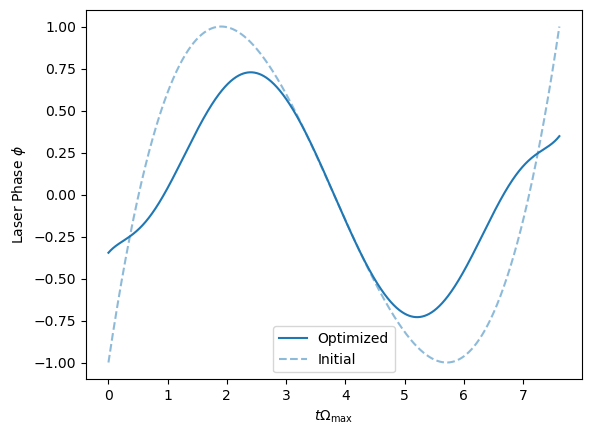

In [7]:
# plot piecewise-continouous gate
# plt.step(np.linspace(0, t_max, n_pieces), res.x[:-1], color="tab:blue", label="Optimized")
# plt.step(np.linspace(0, t_max, n_pieces), alpha0[:-1], alpha=0.35, label="Initial")
# plt.xlabel("$t\\Omega_{\\text{max}}$")
# plt.ylabel("Laser Phase $\\phi$")
# plt.legend()

# plot chebyshev gate
ts = np.linspace(0, t_max, 10001)
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("Laser Phase $\\phi$")
plt.plot(ts, chebyshev.chebval((2/control_extra_params["t_max"])*ts-1, res.x[:-1]), color="tab:blue", label="Optimized")
plt.plot(ts, chebyshev.chebval((2/control_extra_params["t_max"])*ts-1, alpha0), linestyle="--", alpha=0.5, label="Initial")
plt.legend()

plt.show()

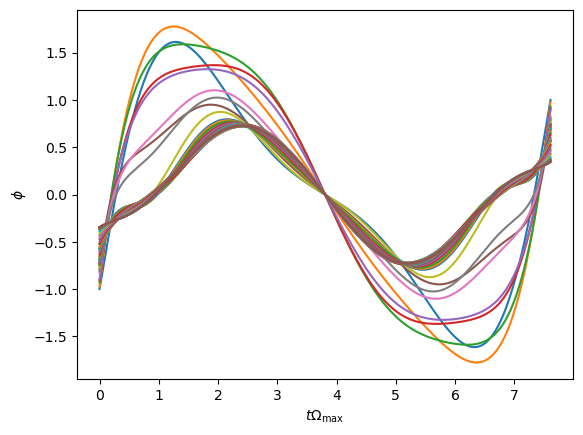

In [12]:
# plot how gate changed during optimization
for i in range(len(prev_params)):
    # plt.step(np.linspace(0, t_max, n_pieces), prev_params[i][:-1], alpha=0.3, label=f"{i}")

    ts = np.linspace(0, t_max, 10001)
    plt.plot(ts, chebyshev.chebval((2/control_extra_params["t_max"])*ts-1, prev_params[i][:-1]))
# plt.step(np.linspace(0, t_max, 100), prev_params[-2][:-1], alpha=0.3) # , label=f"{i}")
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("$\\phi$")
# plt.legend()
plt.show()

/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


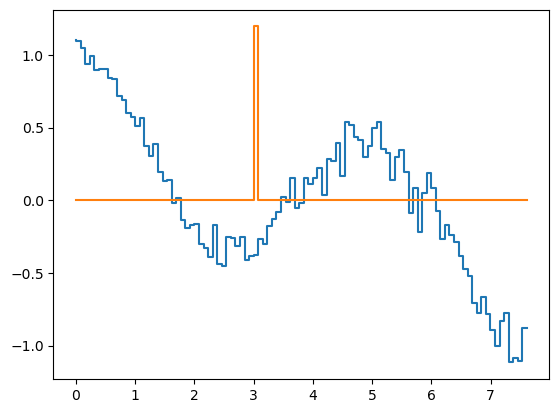

In [6]:
# check that piecewise controls are working
nts = 100
ts = np.linspace(0, t_max, nts)
controls = np.zeros(nts)
control_derivs = np.zeros(nts, dtype=complex)
deriv_j = 40
for i in range(nts):
    cval = to_control_func_plus(ts[i], res.x[:-1], control_extra_params)
    # print(cval)
    controls[i] = np.angle(cval)

    c_derivs = control_param_derivs(ts[i], res.x[:-1], control_extra_params)
    # print(c_derivs)
    control_derivs[i] = np.angle(c_derivs[0][deriv_j])

plt.step(ts, controls)
plt.step(ts, control_derivs)
plt.show()

/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


1-F = 2.1094237467877974e-15


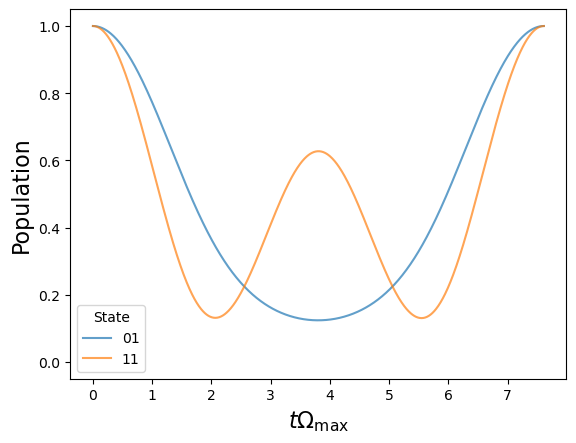

In [8]:
# simulate resulting gate in qutip
to_drive_strength_func = lambda t: 1
to_phase_func = lambda t: data_from_tstep(t, t_steps, alpha0[:-1])
# to_phase_func = lambda t: data_from_tstep(t, t_steps, res.x[:-1])

chebyshev_drive_strength_func = lambda t: 1
chebyshev_phase_func = lambda t: chebyshev.chebval((2/t_max)*t-1, res.x[:-1])

# results = simulate_gate(chebyshev_drive_strength_func, chebyshev_phase_func, 100, 0, t_min, t_max, 1001)
# results = simulate_gate(to_drive_strength_func, to_phase_func, 100, 0, t_min, t_max, 1001)

results = simulate_gate("reduced_ideal_rydberg", chebyshev_drive_strength_func, chebyshev_phase_func, t_min, t_max, 1001, plot=True)
# results = simulate_gate(to_drive_strength_func, to_phase_func, t_min, t_max, 1001)

# print(f"1-F = {calculate_fidelity(results, single_qubit_phase=alpha0[-1])}")
print(f"1-F = {1 - calculate_fidelity("reduced_ideal_rydberg", "TO", results, single_qubit_phase=res.x[-1])}")
plt.show()

-2.1679502583892445
0.9999999997514476


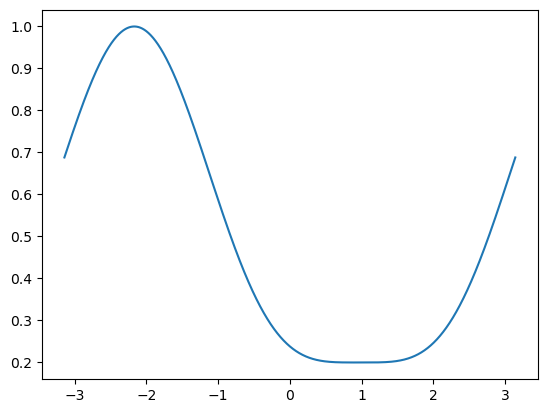

In [9]:
N = 100001
phases = np.linspace(-np.pi, np.pi, N)
fidelities = np.zeros(N)

for i in range(N):
    fidelities[i] = calculate_fidelity("reduced_ideal_rydberg", "TO", results, single_qubit_phase=phases[i])
# print(res.x[-1])
print(phases[np.argmax(fidelities)])
print(np.max(fidelities))

plt.plot(phases, fidelities)
plt.show()

In [8]:
import importlib
import goat_optimization

importlib.reload(goat_optimization)

<module 'goat_optimization' from '/Users/pranav/Documents/School/Princeton/Thesis/noise-robust-gates/goat_optimization.py'>

In [9]:
# calculate fidelity hessian

control_param_hessians = chebyshev_control_param_hessian
alpha = res.x

goat_hessian = goat_optimization.to_infidelity_hessian(
    H0, 
    H_controls, 
    control_funcs, 
    control_param_derivs, 
    control_param_hessians,
    alpha,
    U_target,
    t_span,
    U_truncator,
    single_qubit_phase_weights=[1, 2],
    control_extra_params=control_extra_params,
    ode_rtol=1e-7,
    ode_atol=1e-9,
)

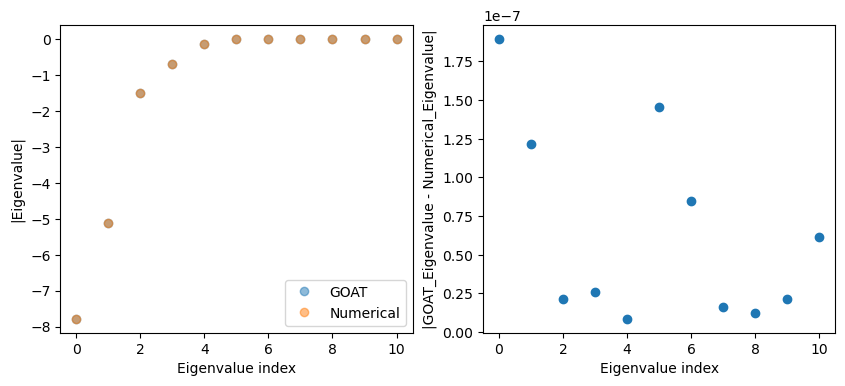

In [12]:
# eigenvalues, eigenvectors = np.linalg.eigh(infidelity_hessian)
goat_eigenvalues, goat_eigenvectors = np.linalg.eigh(goat_hessian)
numerical_eigenvalues, numerical_eigenvectors = np.linalg.eigh(numerical_hessian)


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(goat_eigenvalues, marker="o", linestyle="", alpha=0.5, label="GOAT")
ax[0].plot(numerical_eigenvalues, marker="o", linestyle="", alpha=0.5, label="Numerical")
ax[1].plot(np.abs(goat_eigenvalues - numerical_eigenvalues), marker="o", linestyle="")

ax[0].set_xlabel("Eigenvalue index")
ax[0].set_ylabel("|Eigenvalue|")
ax[0].legend()
ax[1].set_xlabel("Eigenvalue index")
ax[1].set_ylabel("|GOAT_Eigenvalue - Numerical_Eigenvalue|")

plt.show()

In [14]:
# eigenvalues, eigenvectors = np.linalg.eigh(infidelity_hessian)
evec_is = np.arange(n_cheb_polys + 1)

n_evec_pts = 21
evec_strength = np.linspace(-0.1, 0.1, n_evec_pts)
evec_fidelity = np.zeros((n_cheb_polys+1, n_evec_pts))

for evec_i in evec_is:
    for i in range(n_evec_pts):
        alpha_evec = alpha + evec_strength[i] * goat_eigenvectors[:, evec_i]

        chebyshev_drive_strength_func = lambda t: 1
        chebyshev_phase_func = lambda t: chebyshev.chebval((2/t_max)*t-1, alpha_evec[:-1])

        results = simulate_gate("reduced_ideal_rydberg", chebyshev_drive_strength_func, chebyshev_phase_func, t_min, t_max, 1001, plot=False)
        evec_fidelity[evec_i, i] = calculate_fidelity("reduced_ideal_rydberg", "TO", results, single_qubit_phase=alpha_evec[-1])


/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


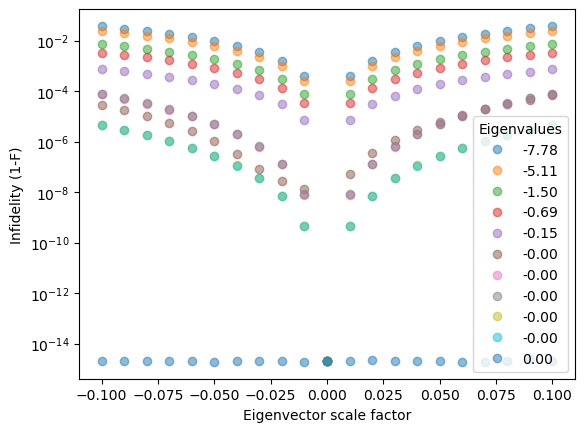

In [15]:
for evec_i in evec_is: 
    plt.semilogy(evec_strength, 1-evec_fidelity[evec_i], marker="o", linestyle="", alpha=0.5, label=f"{goat_eigenvalues[evec_i]:.2f}")

# plt.plot(evec_strength, evec_fidelity[evec_i], marker="o", linestyle="")

plt.xlabel("Eigenvector scale factor")
plt.ylabel("Infidelity (1-F)")
plt.legend(title="Eigenvalues")
plt.show()

## Sweep Gate Time

In [27]:
n_times = 9*5+1
gate_times = np.linspace(7.5, 7.7, n_times)
# n_times = 14*5+1
# gate_times = np.linspace(1, 15, n_times)
goat_results = []
fidelities = np.zeros(n_times)

control_funcs = [chebyshev_control_func_plus, chebyshev_control_func_minus]
control_param_derivs = chebyshev_control_param_derivs

n_cheb_polys = 10
alpha0 = np.zeros(n_cheb_polys + 1)
alpha0[3] = 1

alpha_bounds = np.tile([-1, 1], (n_cheb_polys + 1, 1)).astype(np.float64)
alpha_bounds[-1][0] = -np.pi
alpha_bounds[-1][1] = np.pi

# BFGS
optimizer_opts = {"maxiter": 200, "disp": False, "ftol": 1e-15, "gtol": 1e-15} # for L-BFGS-B

# trust-constr
# optimizer_opts = {"maxiter": 1000, "verbose": 1, "gtol": 1e-10, "xtol": 1e-10, 
#                 "initial_barrier_parameter": 1e-3, "initial_barrier_tolerance": 1e-3, "barrier_tol": 1e-6}

In [28]:
for i in range(n_times):
    t_min = 0
    t_max = gate_times[i] # from TO gates paper 
    t_span = [t_min, t_max]

    control_extra_params = {
        "Omega_max": 1,
        "t_max": gate_times[i],
        # "n_pieces": n_pieces
    }

    res = run_goat_optimization(
        H0,
        H_controls,
        control_funcs,
        control_param_derivs,
        alpha0,
        U_target,
        t_span,
        U_truncator,
        fidelity_func_name="TO",
        optimization_method="BFGS",
        # alpha_bounds=alpha_bounds,
        # constraints=chebyshev_constraint,
        single_qubit_phase_weights=[1, 2],
        control_extra_params=control_extra_params,
        optimizer_opts=optimizer_opts,
        callback=callback
    )

    goat_results.append(res)
    fidelities[i] = res.fun
    print(f"Gate time: {gate_times[i]}, Infidelity: {res.fun}, chebyshev_max = {chebyshev_max(res.x)}")

Gate time: 7.5, Infidelity: 0.0006798714776260484, chebyshev_max = 0.7290168158956634
Gate time: 7.504444444444444, Infidelity: 0.0006271068140267788, chebyshev_max = 0.7286281259824724
Gate time: 7.5088888888888885, Infidelity: 0.0005764399094463357, chebyshev_max = 0.7282385743308704
Gate time: 7.513333333333334, Infidelity: 0.000527875195320382, chebyshev_max = 0.7278469063948448
Gate time: 7.517777777777778, Infidelity: 0.000481417082573099, chebyshev_max = 0.7274545760613185
Gate time: 7.522222222222222, Infidelity: 0.0004370699611854212, chebyshev_max = 0.7270606431940966
Gate time: 7.526666666666666, Infidelity: 0.00039483820023522576, chebyshev_max = 0.726665875181431
Gate time: 7.5311111111111115, Infidelity: 0.0003547261476194441, chebyshev_max = 0.7262696857706428
Gate time: 7.535555555555556, Infidelity: 0.0003167381299181704, chebyshev_max = 0.7258724431160866
Gate time: 7.54, Infidelity: 0.00028087845205337914, chebyshev_max = 0.7254729809765339
Gate time: 7.5444444444444

In [27]:
for result in goat_results:
    print(f"1-F: {result.fun}, nit: {result.nit}")

1-F: 0.3998628453200397, nit: 200
1-F: 0.39971627840417634, nit: 176
1-F: 0.39947585883535675, nit: 156
1-F: 0.399108750014767, nit: 129
1-F: 0.399601705473677, nit: 162
1-F: 0.3993486483353348, nit: 139
1-F: 0.3968531669936569, nit: 137
1-F: 0.39556496466907864, nit: 119
1-F: 0.3939236157415321, nit: 115
1-F: 0.3918732087222888, nit: 111
1-F: 0.38935494293131934, nit: 107
1-F: 0.386307404850463, nit: 102
1-F: 0.3864568640087662, nit: 111
1-F: 0.3397715646438152, nit: 38
1-F: 0.373341371696163, nit: 104
1-F: 0.3120185962325249, nit: 37
1-F: 0.3608311083719431, nit: 103
1-F: 0.3634355198410213, nit: 105
1-F: 0.35668826949726773, nit: 107
1-F: 0.4001240661900578, nit: 177
1-F: 0.38326152004450975, nit: 69
1-F: 0.4012984416848634, nit: 143
1-F: 0.4016397220687531, nit: 104
1-F: 0.3089056841202491, nit: 34
1-F: 0.29738941871910474, nit: 61
1-F: 0.2174602545411446, nit: 55
1-F: 0.27195782494672427, nit: 58
1-F: 0.25810793989277536, nit: 67
1-F: 0.04737335264893483, nit: 31
1-F: 0.0318290954

In [35]:
# load results
import pickle

with open("results/time_sweep_7.pkl", "rb") as file:
    gate_times, goat_results, fidelities = pickle.load(file)

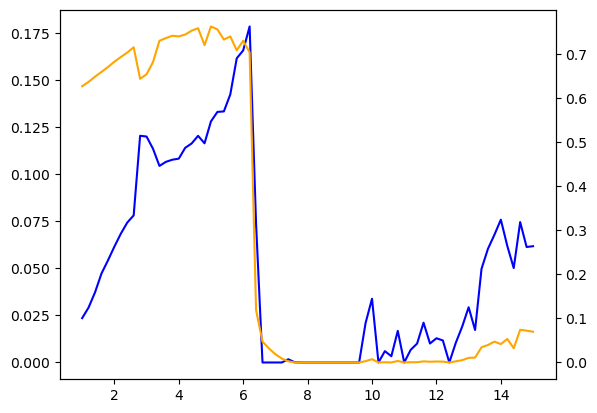

In [ ]:
# check optimizality behavior
optimalities = np.zeros(len(goat_results)) 
for i in range(optimalities.size):
    optimalities[i] = goat_results[i]["optimality"]

fig, ax1 = plt.subplots()
ax1.plot(gate_times, optimalities, color="blue")
ax2 = ax1.twinx()
ax2.plot(gate_times, fidelities, color="orange")

Text(0, 0.5, 'Infidelity')

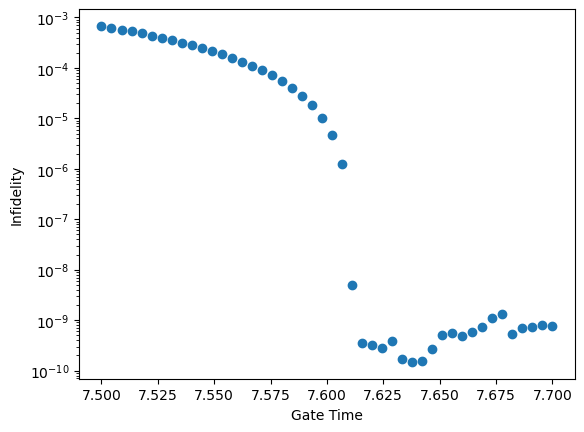

In [30]:
plt.semilogy(gate_times, fidelities, linestyle="", marker="o")
plt.xlabel("Gate Time")
plt.ylabel("Infidelity")

5.4


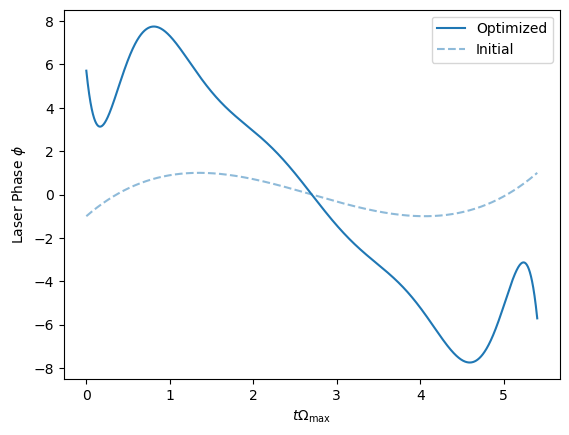

In [15]:
# plot (chebyshev) gate

iter_num = 22

print(gate_times[iter_num])

ts = np.linspace(0, gate_times[iter_num], 10001)
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("Laser Phase $\\phi$")
plt.plot(ts, chebyshev.chebval((2/gate_times[iter_num])*ts-1, goat_results[iter_num].x[:-1]), color="tab:blue", label="Optimized")
plt.plot(ts, chebyshev.chebval((2/gate_times[iter_num])*ts-1, alpha0), linestyle="--", alpha=0.5, label="Initial")
plt.legend()

plt.show()

single qubit phase: 14.075905661978789
fidelity: 0.706998387941636


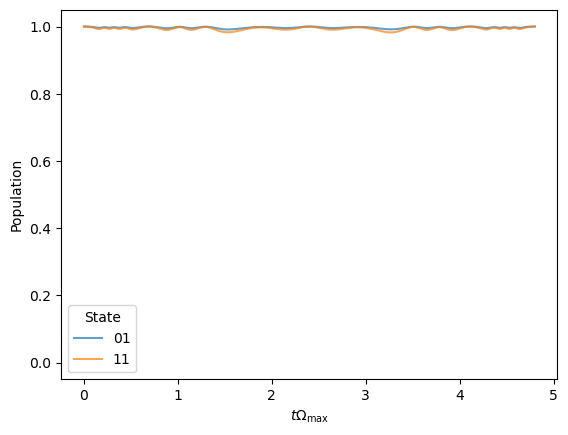

In [52]:
# qutip simulation of chebyshev gate
chebyshev_drive_strength_func = lambda t: 1
chebyshev_phase_func = lambda t: chebyshev.chebval((2/gate_times[iter_num])*t-1, goat_results[iter_num].x[:-1])

results = simulate_gate(chebyshev_drive_strength_func, chebyshev_phase_func, 0, gate_times[iter_num], 1001, plot=True)
print(f"single qubit phase: {goat_results[iter_num].x[-1]}")

fidelity = calculate_fidelity(results, single_qubit_phase=goat_results[iter_num].x[-1])
print(f"fidelity: {fidelity}")

best phase: -1.6317432242745387
best fidelity: 0.7072113022830925


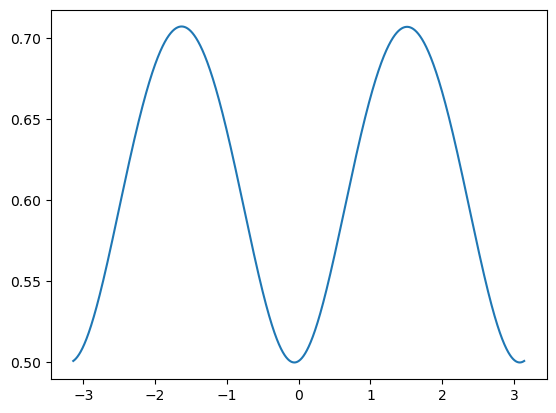

In [54]:
N = 10001
phases = np.linspace(-np.pi, np.pi, N)
phase_sweep_fidelities = np.zeros(N)

for i in range(N):
    phase_sweep_fidelities[i] = calculate_fidelity(results, single_qubit_phase=phases[i])
# print(res.x[-1])
print(f"best phase: {phases[np.argmax(phase_sweep_fidelities)]}")
print(f"best fidelity: {np.max(phase_sweep_fidelities)}")

plt.plot(phases, phase_sweep_fidelities)
plt.show()

In [31]:
# test results using QuTiP simulations
simulated_fidelities_to = np.zeros(n_times)
simulated_fidelities_goat = np.zeros(n_times)

for i in range(n_times):
    chebyshev_drive_strength_func = lambda t: 1
    chebyshev_phase_func = lambda t: chebyshev.chebval((2/gate_times[i])*t-1, goat_results[i].x[:-1])

    # results = simulate_gate(chebyshev_drive_strength_func, chebyshev_phase_func, 100, 0, t_min, gate_times[i], 1001, plot=False)
    # results = simulate_gate(chebyshev_drive_strength_func, chebyshev_phase_func, 100, 0, 0, gate_times[i], 1001, plot=False)

    # without finite blockade
    results = simulate_gate(chebyshev_drive_strength_func, chebyshev_phase_func, 0, gate_times[i], 1001, plot=False)

    simulated_fidelities_to[i] = calculate_fidelity(results, single_qubit_phase=goat_results[i].x[-1], metric="TO")
    simulated_fidelities_goat[i] = calculate_fidelity(results, single_qubit_phase=goat_results[i].x[-1], metric="GOAT")

    # print(f"Gate Time: {gate_times[i]}, Fidelity: {simulated_fidelities[i]}")

/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


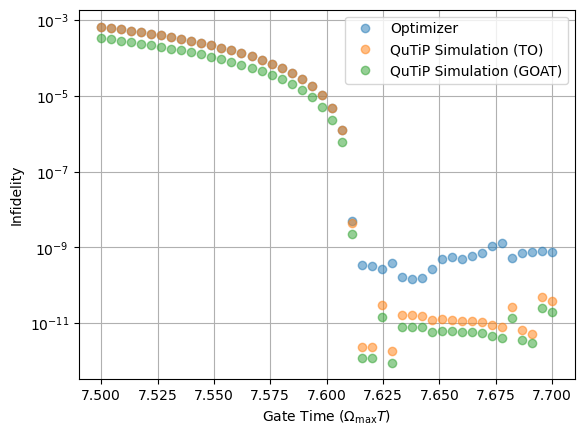

In [32]:
# plot simulated fidelities
plt.semilogy(gate_times, fidelities, linestyle="", marker="o", alpha=0.5, label="Optimizer")
plt.semilogy(gate_times, 1 - simulated_fidelities_to, linestyle="", marker="o", alpha=0.5, label="QuTiP Simulation (TO)")
plt.semilogy(gate_times, 1 - simulated_fidelities_goat, linestyle="", marker="o", alpha=0.5, label="QuTiP Simulation (GOAT)")
plt.xlabel("Gate Time ($\\Omega_{\\text{max}}T$)")
plt.ylabel("Infidelity")
plt.grid()
plt.legend()
plt.show()

## Sweeping Number of Parameters

In [44]:
n_cheb_polys = np.arange(4, 31, 2)
n_iters = n_cheb_polys.size
goat_results = []
fidelities = np.zeros(n_iters)

control_funcs = [chebyshev_control_func_plus, chebyshev_control_func_minus]
control_param_derivs = chebyshev_control_param_derivs

t_min = 0
t_max = 7.612 # from TO gates paper 
t_span = [t_min, t_max]

control_extra_params = {
    "Omega_max": 1,
    "t_max": t_max
    # "n_pieces": n_pieces
}

optimizer_opts = {"maxiter": 400, "disp": False, "ftol": 1e-15, "gtol": 1e-15} # for L-BFGS-B
# optimizer_opts = {"maxiter": 1000, "verbose": 1, "gtol": 1e-10, "xtol": 1e-10, 
#                     "initial_barrier_parameter": 1e-3, "initial_barrier_tolerance": 1e-3, "barrier_tol": 1e-6} # for trust-constr

In [ ]:
for i in range(n_iters):
    alpha0 = np.zeros(n_cheb_polys[i] + 1)
    alpha0[3] = 1

    res = run_goat_optimization(
        H0,
        H_controls,
        control_funcs,
        control_param_derivs,
        alpha0,
        U_target,
        t_span,
        U_truncator,
        optimization_method="BFGS",
        fidelity_func_name="GOAT_full",
        # alpha_bounds=alpha_bounds,
        # constraints=chebyshev_constraint,
        single_qubit_phase_weights=[1, 2],
        control_extra_params=control_extra_params,
        optimizer_opts=optimizer_opts,
        callback=callback
    )

    goat_results.append(res)
    fidelities[i] = res.fun

    print(f"Number of Coefficients: {n_cheb_polys[i]}, 1-F: {fidelities[i]}, chebyshev_max: {chebyshev_max(res.x)}")

Number of Coefficients: 4, 1-F: 0.0023804539969831673, chebyshev_max: 1.0700818339711242
Number of Coefficients: 6, 1-F: 4.996386132605224e-07, chebyshev_max: 0.7240472158127522
Number of Coefficients: 8, 1-F: 6.995457546565831e-10, chebyshev_max: 0.7219211661460024
Number of Coefficients: 10, 1-F: 1.1535239430315869e-10, chebyshev_max: 0.7158554206008632
Number of Coefficients: 12, 1-F: 3.28161942064753e-11, chebyshev_max: 0.7244781960943519
Number of Coefficients: 14, 1-F: 9.89763826453327e-12, chebyshev_max: 0.7279916101703742
Number of Coefficients: 16, 1-F: 6.674438779441516e-12, chebyshev_max: 0.7267287057707723
Number of Coefficients: 18, 1-F: 5.312639217436299e-12, chebyshev_max: 0.7128738205583587
Number of Coefficients: 20, 1-F: 3.2688296514038484e-12, chebyshev_max: 0.7228522069035734
Number of Coefficients: 22, 1-F: 2.950750754848741e-12, chebyshev_max: 0.7116723278918512
Number of Coefficients: 24, 1-F: 2.677746913093415e-12, chebyshev_max: 0.7170961057112462
Number of Coe

In [53]:
# load results
import pickle

with open("results/num_coefficients_sweep_6.pkl", "rb") as file:
    n_cheb_polys, goat_results, fidelities = pickle.load(file)

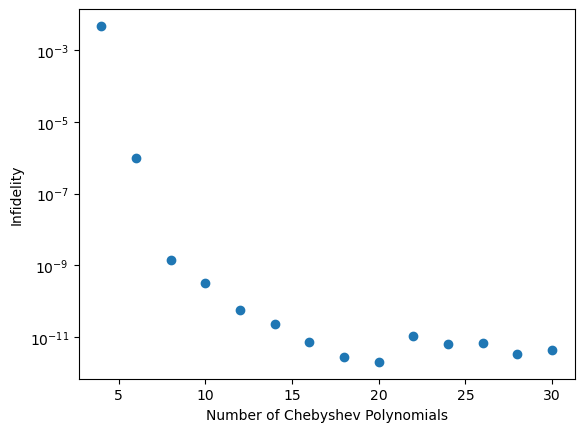

In [54]:
plt.semilogy(n_cheb_polys, fidelities, linestyle="", marker="o")
plt.xlabel("Number of Chebyshev Polynomials")
plt.ylabel("Infidelity")
plt.show()

28


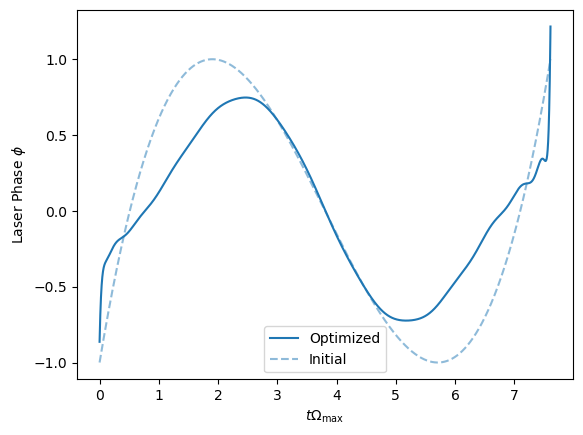

In [10]:
# plot (chebyshev) gate

iter_num = -1

print(n_cheb_polys[iter_num])

ts = np.linspace(0, t_max, 10001)
plt.xlabel("$t\\Omega_{\\text{max}}$")
plt.ylabel("Laser Phase $\\phi$")
plt.plot(ts, chebyshev.chebval((2/t_max)*ts-1, goat_results[iter_num].x[:-1]), color="tab:blue", label="Optimized")
plt.plot(ts, chebyshev.chebval((2/t_max)*ts-1, alpha0), linestyle="--", alpha=0.5, label="Initial")
plt.legend()

plt.show()

In [55]:
# test results using QuTiP simulations
simulated_fidelities_to = np.zeros(n_iters)
simulated_fidelities_goat = np.zeros(n_iters)

for i in range(n_iters):
    chebyshev_drive_strength_func = lambda t: 1
    chebyshev_phase_func = lambda t: chebyshev.chebval((2/t_max)*t-1, goat_results[i].x[:-1])

    # results = simulate_gate(chebyshev_drive_strength_func, chebyshev_phase_func, 100, 0, t_min, t_max, 1001, plot=False)

    # using simplified basis
    results = simulate_gate(chebyshev_drive_strength_func, chebyshev_phase_func, t_min, t_max, 1001, plot=False)
    simulated_fidelities_to[i] = calculate_fidelity(results, single_qubit_phase=goat_results[i].x[-1], metric="TO")
    simulated_fidelities_goat[i] = calculate_fidelity(results, single_qubit_phase=goat_results[i].x[-1], metric="GOAT")

    # print(f"Number of Chebyshev Coefficients: {n_cheb_polys[i]}, Fidelity: {simulated_fidelities[i]}")

/opt/miniconda3/envs/miscenv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


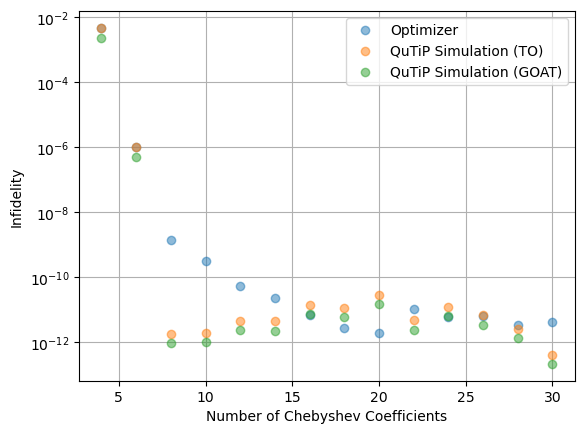

In [56]:
# plot simulated fidelities
plt.semilogy(n_cheb_polys, fidelities, linestyle="", marker="o", alpha=0.5, label="Optimizer")
plt.semilogy(n_cheb_polys, 1 - simulated_fidelities_to, linestyle="", marker="o", alpha=0.5, label="QuTiP Simulation (TO)")
plt.semilogy(n_cheb_polys, 1 - simulated_fidelities_goat, linestyle="", marker="o", alpha=0.5, label="QuTiP Simulation (GOAT)")
# plt.plot(n_cheb_polys[1:], (1 - simulated_fidelities)[1:], linestyle="", marker="o")
plt.xlabel("Number of Chebyshev Coefficients")
plt.ylabel("Infidelity")
plt.grid()
plt.legend()
plt.show()

## Save Results

In [14]:
# save results
import pickle

# with open("results/goat_run_19.pkl", "wb") as f:
#     pickle.dump((res, prev_params), f)

# with open("results/time_sweep_9.pkl", "wb") as f:
#     pickle.dump((gate_times, goat_results, fidelities), f)

with open("results/num_coefficients_sweep_7.pkl", "wb") as f:
    pickle.dump((n_cheb_polys, goat_results, fidelities), f)

In [ ]:
# exporting to pulse format for qutip simulations
with open("results/goat_run_13.pkl", "rb") as file:
    (loaded_res, loaded_prev_params) = pickle.load(file)

times = np.linspace(0, t_max, n_pieces)
phases = loaded_res.x[:-1]
Omegas = control_extra_params["Omega_max"] * np.ones(n_pieces)


np.savetxt("pulses/goat_gate4_best.csv", np.column_stack((times, Omegas, phases)), delimiter=",", header="t,|Omega|,arg(Omega)")

In [3]:
taxtip_pp = (27.18 + 15.10 + 4.53) / 5
print(taxtip_pp)
print(taxtip_pp * 4)

9.362
37.448
